In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from LPSolver import LPSolver
import cvxpy as cp

Not able to run tests with GPU
Not able to run with GPU


In [3]:
rng = np.random.default_rng(10)

### Generate a feasible problem instance

In [223]:
m = 800  # number of equality constraints -- keep lower than number of variables to ensure there are multiple solutions to the problem
n = 1000  # number of variables

A = rng.normal(size = (m,n))

random_row_index = np.random.choice(m)

# Set all entries in the selected row to their absolute values
A[random_row_index, :] = np.abs(A[random_row_index, :])

b = A@np.abs(rng.normal(size = (n,)))
c = rng.normal(size = (n,))

In [228]:
n = 1000
m = 500
C = np.random.random((m,n))
C = np.where(np.random.binomial(1, 0.10, C.shape), C, 0)  # <- apply a random mask with 10% density  (A will be 90% sparse)
d = np.random.randint(low=1, high=30, size=C.shape[0])
# b_vec = np.sum(A, axis=1) + 10

c = np.random.randint(low=1, high=n, size=C.shape[1]) - n/2

Not able to run tests with GPU


### Create a LPSolver object

Can specify use_gpu = True if you want to run with a GPU. GPU solver typically starts to surpass performance of CPU solver ~500 variables (depending on system)

Also able to make multiple instances of this object to compare different hyperparameters

In [229]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax == b
                   Cx <= d
                   x >= 0

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
Set sign = +/- 1 if you want to constraint x to be positive or negative
"""
#A = np.zeros((2, len(c)))
#A[0,148] = 5
#A[1,590] = 4.5
#b = np.array([2,2])

ls= LPSolver(c=c,
        A=None,
        b=None,
        C=C,
        d=d,
        use_gpu=False,
        sign=1,
        t0=1,
        max_outer_iters=50,
        max_inner_iters=20,
        epsilon=1e-8,
        inner_epsilon=1e-5,
        check_cvxpy=True,
        linear_solve_method="cholesky",
        max_cg_iters=50,
        alpha=0.2,
        beta=0.6,
        mu=15,
        suppress_print=True)


Warning, Newtons method ran its maximum number of steps
Warning, Newtons method ran its maximum number of steps
Is testing CVXPY


#### Compare LPSolver solution to the CVXPY solution
Check the ls.value parameter if you want to extract the value of the solution, use ls.xstar to get the minimizer

In [230]:
ls.solve(track_loss=True) - ls.cvxpy_val

0.006154077807877911

In [231]:
ls.inner_iters

[17, 6, 4, 10, 2, 3, 3, 3, 2, 3, 20]

<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

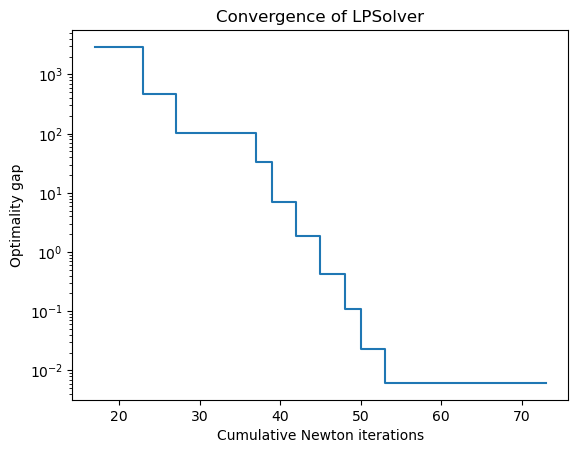

In [232]:
ls.plot()

### Benchmark LPSolver times vs. CVXPY
Can also generate multiple instances of LP to benchmark times of different hyperparameters

In [ ]:
%%timeit
x = cp.Variable(len(c))
obj = cp.Minimize(c.T@x)
constr = [A@x == b,
        x <= 0]
prob = cp.Problem(obj, constr)
prob.solve(solver='CLARABEL')


4.71 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls.solve(resolve=True)

2.03 s ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls_gpu.solve(resolve=True)

250 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

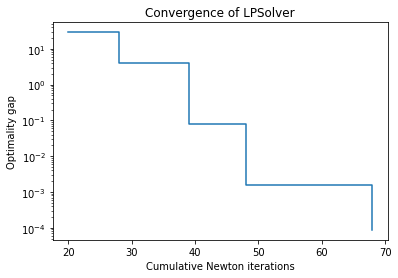

In [ ]:
ls_gpu.plot()